In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

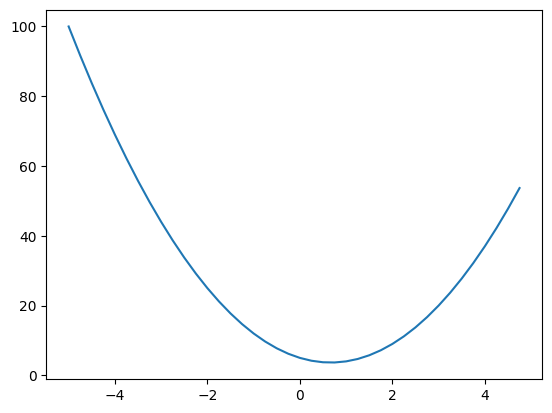

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [86]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [77]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.label = label
        self.grad = 0.0
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward(): # for additions, each elements gradient becomes results grad.
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Value(x, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - x**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        x = max(0, self.data)
        out = Value(x, (self, ), 'relu')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def backward(self):
        # topological sort the children
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

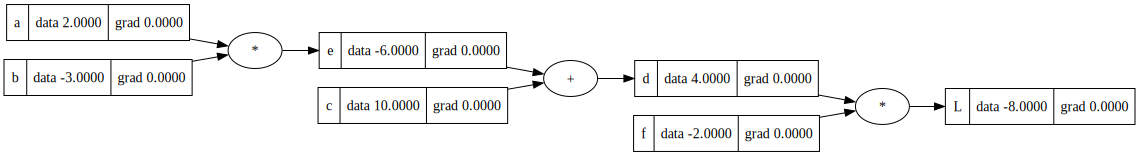

In [78]:
draw_dot(L)

In [39]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0
# calculate dL/dd
# L = d * f => dL/dd = (d * 0) + (f * 1) = f
# calculate dL/df
# L = d * f => dL/df = (d * 1) + (f * 0) = d

## when multiplying, the deriv of the answer is always going to be the opposite variable

## how about when multiplying three variables? lets assume there was f * d * z = L
## dL / dz = (fd) * z = (fd) * 1  + (1 * 0) = fd
## the derivative will always be the other products that the equation is not in respect to. [FOR PRODUCTS ONLY]

# calculate dL/de
# e + c = d
# dd/de = 1 and then dL / dd = -2 thus dL/de = -2 * 1 - 02
# dL/db but first we find de/db e = b * a  => de/db = a


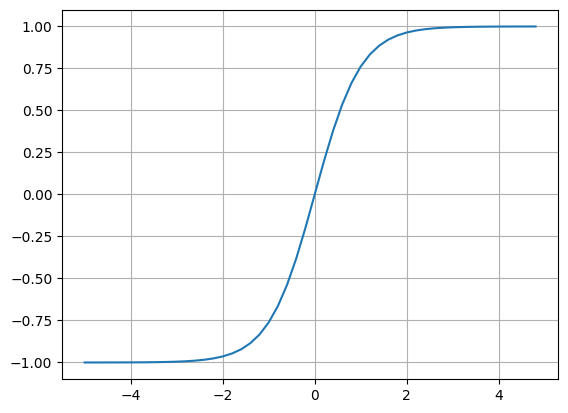

In [40]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

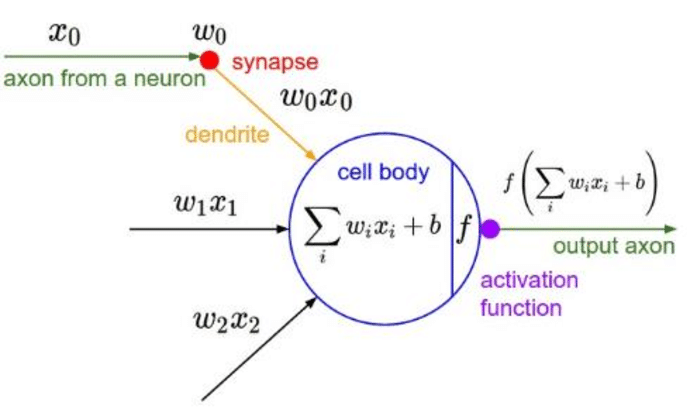

In [68]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# neuron bias
b = Value(6.8813735870, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

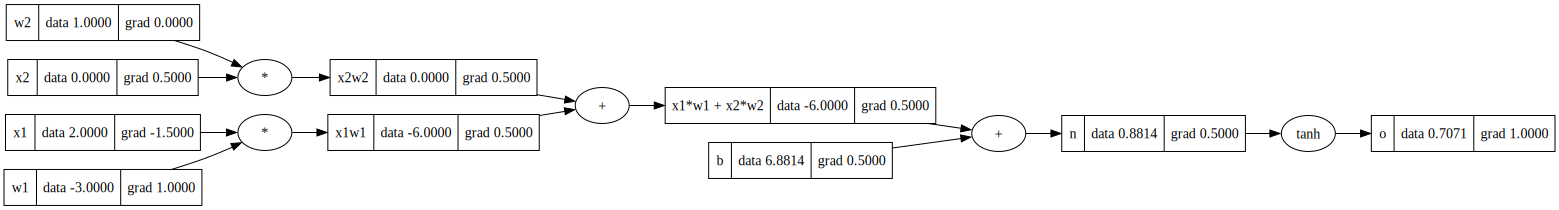

In [72]:
draw_dot(o)

In [71]:
backward(o)